# Libraries

In [11]:
from pathlib import Path
import numpy as np

from src.data_processing import DataProcessor, SMOTEN
from src.visualization import EDAVisualizer

# Data Prep

In [12]:
is_train = input("Is this preprocessing for training data? (y/n): ").lower() == 'y'

In [13]:
if is_train:
    data_path = Path("./data/raw/aug_train.csv")
else:
    data_path = Path("./data/raw/aug_test.csv")

# Read first line as header
with open(data_path, "r", encoding="utf-8") as f:
    data_header = f.readline().strip().split(",")

data = np.genfromtxt(data_path, delimiter=",", skip_header=1, dtype=str)
data[:5]

array([['8949', 'city_103', '0.92', 'Male', 'Has relevent experience',
        'no_enrollment', 'Graduate', 'STEM', '>20', '', '', '1', '36',
        '1.0'],
       ['29725', 'city_40', '0.7759999999999999', 'Male',
        'No relevent experience', 'no_enrollment', 'Graduate', 'STEM',
        '15', '50-99', 'Pvt Ltd', '>4', '47', '0.0'],
       ['11561', 'city_21', '0.624', '', 'No relevent experience',
        'Full time course', 'Graduate', 'STEM', '5', '', '', 'never',
        '83', '0.0'],
       ['33241', 'city_115', '0.789', '', 'No relevent experience', '',
        'Graduate', 'Business Degree', '<1', '', 'Pvt Ltd', 'never',
        '52', '1.0'],
       ['666', 'city_162', '0.767', 'Male', 'Has relevent experience',
        'no_enrollment', 'Masters', 'STEM', '>20', '50-99',
        'Funded Startup', '4', '8', '0.0']], dtype='<U23')

# Preprocessing

I will implement preprocessing steps that are suitable for Naive Bayes models.

## Drop columns

In [14]:
# drop enrollee_id because it is just an identifier
# drop city_development_index because it is paired with city, one of them is enough
# drop training_hours because it has very low correlation with the target variable
drop_columns = ["city_development_index", "training_hours"]
if is_train:
    drop_columns.append("enrollee_id")
data = data[:, [i for i, col in enumerate(data_header) if col not in drop_columns]]
data_header = [col for col in data_header if col not in drop_columns]

In [15]:
data[:5]

array([['city_103', 'Male', 'Has relevent experience', 'no_enrollment',
        'Graduate', 'STEM', '>20', '', '', '1', '1.0'],
       ['city_40', 'Male', 'No relevent experience', 'no_enrollment',
        'Graduate', 'STEM', '15', '50-99', 'Pvt Ltd', '>4', '0.0'],
       ['city_21', '', 'No relevent experience', 'Full time course',
        'Graduate', 'STEM', '5', '', '', 'never', '0.0'],
       ['city_115', '', 'No relevent experience', '', 'Graduate',
        'Business Degree', '<1', '', 'Pvt Ltd', 'never', '1.0'],
       ['city_162', 'Male', 'Has relevent experience', 'no_enrollment',
        'Masters', 'STEM', '>20', '50-99', 'Funded Startup', '4', '0.0']],
      dtype='<U23')

## Missing Value Handling

In [16]:
# Impute by mode
columns_to_impute = ['enrolled_university', 'major_discipline', 'experience', 'education_level', 'last_new_job' ]
columns_to_impute = [i for i, col in enumerate(data_header) if col in columns_to_impute]
data, _ = DataProcessor.impute_by_mode(data, columns_to_impute)

In [17]:
# Impute as category
columns_to_impute = ['gender', 'company_size', 'company_type']
columns_to_impute = [i for i, col in enumerate(data_header) if col in columns_to_impute]
data, _ = DataProcessor.impute_as_category(data, columns_to_impute)

In [18]:
# Check
for i, feature in enumerate(data_header):
    missing_count = np.sum(data[:, i] == "")
    print(f"Feature '{feature}' has {missing_count} missing values. Percentage: {missing_count / len(data) * 100:.2f}%")

Feature 'city' has 0 missing values. Percentage: 0.00%
Feature 'gender' has 0 missing values. Percentage: 0.00%
Feature 'relevent_experience' has 0 missing values. Percentage: 0.00%
Feature 'enrolled_university' has 0 missing values. Percentage: 0.00%
Feature 'education_level' has 0 missing values. Percentage: 0.00%
Feature 'major_discipline' has 0 missing values. Percentage: 0.00%
Feature 'experience' has 0 missing values. Percentage: 0.00%
Feature 'company_size' has 0 missing values. Percentage: 0.00%
Feature 'company_type' has 0 missing values. Percentage: 0.00%
Feature 'last_new_job' has 0 missing values. Percentage: 0.00%
Feature 'target' has 0 missing values. Percentage: 0.00%


In [19]:
data[:3]

array([['city_103', 'Male', 'Has relevent experience', 'no_enrollment',
        'Graduate', 'STEM', '>20', 'Missing', 'Missing', '1', '1.0'],
       ['city_40', 'Male', 'No relevent experience', 'no_enrollment',
        'Graduate', 'STEM', '15', '50-99', 'Pvt Ltd', '>4', '0.0'],
       ['city_21', 'Missing', 'No relevent experience',
        'Full time course', 'Graduate', 'STEM', '5', 'Missing',
        'Missing', 'never', '0.0']], dtype='<U23')

In [20]:
# if test data, skip SMOTEN
if not is_train:
    processed_data_path = Path("./data/processed/processed_test.csv")
    np.savetxt(processed_data_path, data, delimiter=",", header=",".join(data_header), comments="", fmt="%s")
    raise SystemExit("Test data processed and saved. Skipping SMOTEN.")

# SMOTEN

SMOTEN is a technique for handling imbalanced datasets with categorical features. It works by generating synthetic samples for the minority class using a combination of oversampling and nearest neighbor techniques specifically designed for categorical data.

In [21]:
X_train = data[:, :-1]
y_train = data[:, -1]

In [22]:
smoten = SMOTEN(k_neighbors=5, random_state=42)

X_train, y_train = smoten.fit_resample(X_train, y_train)

Original class distribution:
  Class 0.0: 14381 samples
  Class 1.0: 4777 samples
Generating 9604 synthetic samples for class 1.0...

Resampled class distribution:
  Class 0.0: 14381 samples
  Class 1.0: 14381 samples


# Check

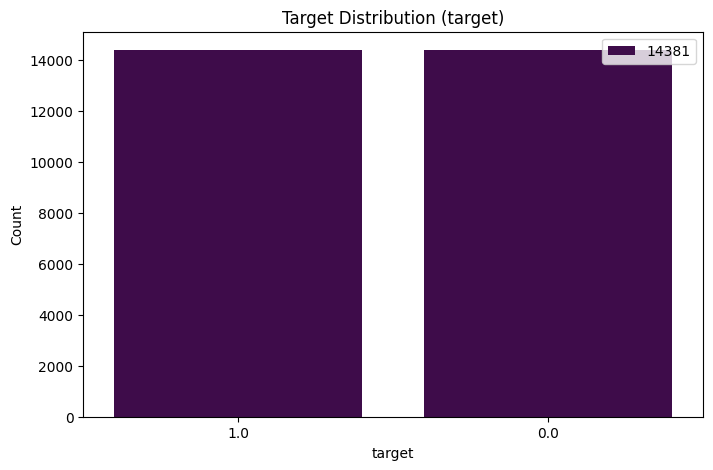

In [23]:
EDAVisualizer.plot_target_distribution(y_train, "target")

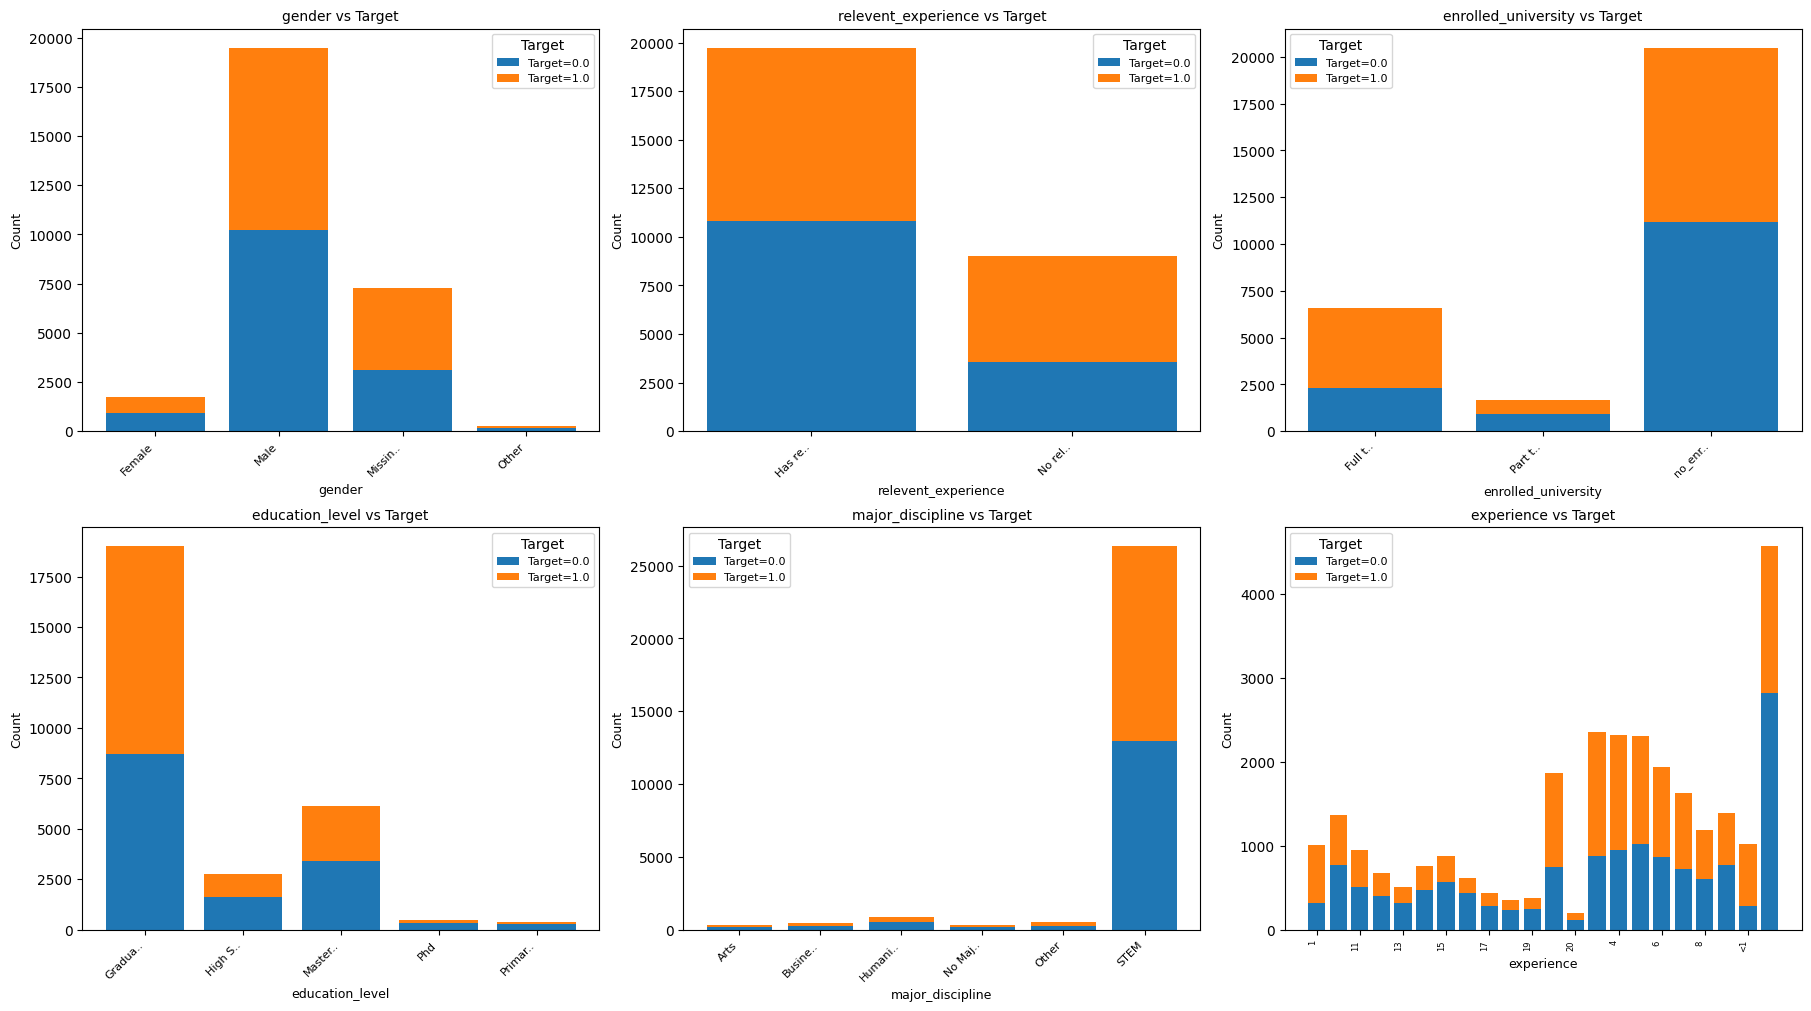

In [24]:
cat_data = X_train[
    :,
    [
        data_header.index(col)
        for col in [
            "gender",
            "relevent_experience",
            "enrolled_university",
            "education_level",
            "major_discipline",
            "experience",
        ]
    ],
]
target_data = y_train
cat_col_names = [
    "gender",
    "relevent_experience",
    "enrolled_university",
    "education_level",
    "major_discipline",
    "experience",
]

EDAVisualizer.plot_categorical_vs_target(
    cat_data=cat_data,
    target_data=target_data,
    cat_col_names=cat_col_names,
)

# Save

In [25]:
processed_data_path = Path("./data/processed/processed_train.csv")
np.savetxt(processed_data_path, np.column_stack((X_train, y_train)), delimiter=",", header=",".join(data_header), comments="", fmt="%s")